<div style="color:#211C84; text-align:center; display:fill;
            border-radius:12px; padding:10px; font-size:180%;
            font-weight:bold; letter-spacing:1.5px;
            background-color:#B5A8D5;
            background-image: url(https://i.imgur.com/GVd0La1.png)">
    Developing U-Net diffusion based model
</div>


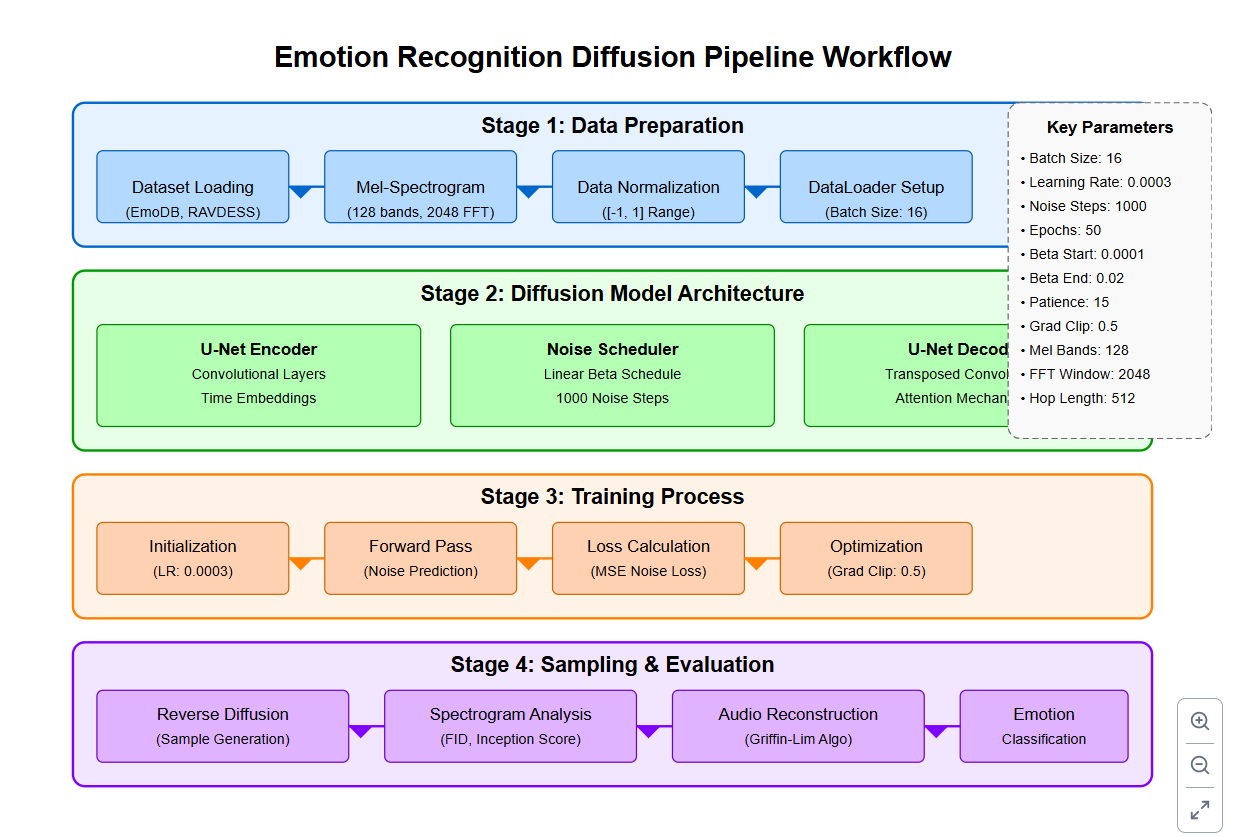

## <b>5 <span style='color:#B5A8D5'>|</span> U-Net diffusion based Modeling </b>

<div style="color:white;display:fill;border-radius:8px;
            background-color:#B5A8D5;font-size:150%;
            letter-spacing:1.0px;background-image: url(https://i.imgur.com/GVd0La1.png)">
    <p style="padding: 8px;color:#211C84;"><b><b><span style='color:#211C84'>5.1 |</span></b> Data Loading </b></p>
</div>

In [1]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm import tqdm
import time
import json
import gc
from datetime import datetime
import librosa
import librosa.display


# =================================================
# CONFIGURATION PARAMETERS
# =================================================

# Define constants for reproducibility
BATCH_SIZE = 8
LEARNING_RATE = 0.0002
NUM_EPOCHS = 1
NOISE_STEPS = 1000  # Number of noise steps in the diffusion process
BETA_START = 0.0001  # Starting noise schedule value
BETA_END = 0.02  # Ending noise schedule value
IMAGE_SIZE = 128  # Target spectrogram size (will be resized if needed)
CHANNELS = 1  # Grayscale spectrograms
PATIENCE = 10  # Early stopping patience
GRAD_CLIP = 1.0  # Gradient clipping threshold
MEMORY_EFFICIENT = True  # Enable memory-efficient processing

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Set device for computation
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"🔧 Using device: {DEVICE}")
if torch.cuda.is_available():
    print(f"   {torch.cuda.get_device_name(0)}")

# Define paths - assuming base structure from VAE code
EXPERIMENTS_DIR = Path("../experiments")
EXPERIMENTS_DIR.mkdir(exist_ok=True, parents=True)

# Create a unique experiment folder with timestamp
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
EXPERIMENT_DIR = EXPERIMENTS_DIR / f"diffusion_experiment_{timestamp}"
EXPERIMENT_DIR.mkdir(exist_ok=True)

# Create subdirectories
MODELS_DIR = EXPERIMENT_DIR / "models"
MODELS_DIR.mkdir(exist_ok=True)
VIZ_DIR = EXPERIMENT_DIR / "visualizations"
VIZ_DIR.mkdir(exist_ok=True)
LOGS_DIR = EXPERIMENT_DIR / "logs"
LOGS_DIR.mkdir(exist_ok=True)
SAMPLES_DIR = EXPERIMENT_DIR / "generated_samples"
SAMPLES_DIR.mkdir(exist_ok=True)

# Save experiment configuration
CONFIG = {
    "batch_size": BATCH_SIZE,
    "learning_rate": LEARNING_RATE,
    "num_epochs": NUM_EPOCHS,
    "noise_steps": NOISE_STEPS,
    "beta_start": BETA_START,
    "beta_end": BETA_END,
    "image_size": IMAGE_SIZE,
    "channels": CHANNELS,
    "patience": PATIENCE,
    "grad_clip": GRAD_CLIP,
    "device": str(DEVICE),
    "timestamp": timestamp,
    "datasets": ["emodb", "ravDESS"]
}

with open(EXPERIMENT_DIR / "config.json", "w") as f:
    json.dump(CONFIG, f, indent=4)

# =================================================
# DATASET CLASS
# =================================================

class SpectrogramDataset(Dataset):
    """Dataset for audio emotion spectrograms."""
    def __init__(self, specs, transform=None):
        self.specs = specs
        self.transform = transform

    def __len__(self):
        return len(self.specs)

    def __getitem__(self, idx):
    # Get spectrogram
        spec = self.specs[idx]

    # Convert to tensor if it's a numpy array
        if isinstance(spec, np.ndarray):
            spec = torch.from_numpy(spec).float()
        elif isinstance(spec, torch.Tensor):
            spec = spec.float()  # Ensure it's a float tensor
        else:
            raise TypeError(f"Unsupported spectrogram type: {type(spec)}")

    # Add channel dimension if needed (for CNNs)
        if len(spec.shape) == 2:
            spec = spec.unsqueeze(0)  # [C, H, W]

    # Apply transforms if any
        if self.transform:
            spec = self.transform(spec)

        return spec


def load_spectrograms(input_dir, max_samples=None):
    """Load spectrograms from directory."""
    spec_files = list(Path(input_dir).glob("*.npy"))

    if max_samples:
        spec_files = spec_files[:max_samples]

    specs = []
    for file in tqdm(spec_files, desc="Loading spectrograms"):
        try:
            spec = np.load(file)
            specs.append(spec)
        except Exception as e:
            print(f"Error loading {file}: {e}")

    print(f"Loaded {len(specs)} spectrograms")
    return specs



C:\Users\dhouh\anaconda3\Lib\site-packages\paramiko\pkey.py:82: CryptographyDeprecationWarning: TripleDES has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.TripleDES and will be removed from this module in 48.0.0.
  "cipher": algorithms.TripleDES,
C:\Users\dhouh\anaconda3\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.Blowfish and will be removed from this module in 45.0.0.
  "class": algorithms.Blowfish,
C:\Users\dhouh\anaconda3\Lib\site-packages\paramiko\transport.py:243: CryptographyDeprecationWarning: TripleDES has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.TripleDES and will be removed from this module in 48.0.0.
  "class": algorithms.TripleDES,


🔧 Using device: cpu


<div style="color:white;display:fill;border-radius:8px;
            background-color:#B5A8D5;font-size:150%;
            letter-spacing:1.0px;background-image: url(https://i.imgur.com/GVd0La1.png)">
    <p style="padding: 8px;color:#211C84;"><b><b><span style='color:#211C84'>5.2 |</span></b> Data Preparation </b></p>
</div>

In [2]:
def preprocess_spectrograms(specs, target_size=IMAGE_SIZE):
    """Preprocess spectrograms to consistent shape."""
    from torch.nn import functional as F

    result = []
    for spec in specs:
        # Convert to torch tensor if it's a numpy array
        if isinstance(spec, np.ndarray):
            spec = torch.from_numpy(spec).float()

        # Ensure we have a batch dimension
        if len(spec.shape) == 2:
            spec = spec.unsqueeze(0)  # Add channel dimension [C, H, W]

        # Resize to target shape
        if spec.shape[1] != target_size or spec.shape[2] != target_size:
            spec = F.interpolate(
                spec.unsqueeze(0),  # Add batch dimension for interpolation
                size=(target_size, target_size),
                mode='bilinear',
                align_corners=False
            ).squeeze(0)  # Remove batch dimension

        # Normalize to [-1, 1] range for diffusion model
        if spec.min() >= 0 and spec.max() <= 1:
            spec = spec * 2 - 1
        elif spec.min() >= -1 and spec.max() <= 1:
            pass  # Already in correct range
        else:
            # Normalize using min-max scaling
            spec_min = spec.min()
            spec_max = spec.max()
            if spec_max > spec_min:  # Avoid division by zero
                spec = 2 * (spec - spec_min) / (spec_max - spec_min) - 1
            else:
                spec = torch.zeros_like(spec)

        result.append(spec)

    # Stack all spectrograms into a batch
    return torch.stack(result)

<div style="color:white;display:fill;border-radius:8px;
            background-color:#B5A8D5;font-size:150%;
            letter-spacing:1.0px;background-image: url(https://i.imgur.com/GVd0La1.png)">
    <p style="padding: 8px;color:#211C84;"><b><b><span style='color:#211C84'>5.3 |</span></b> U-Net Architecture </b></p>
</div>

In [3]:

# =================================================
# DIFFUSION MODEL DEFINITION
# =================================================

def get_index_from_list(vals, t, x_shape):
    """Helper function to extract appropriate tensors from a list of values."""
    batch_size = t.shape[0]
    out = vals.gather(-1, t.cpu())
    return out.reshape(batch_size, *((1,) * (len(x_shape) - 1))).to(t.device)

def linear_beta_schedule(timesteps, beta_start=BETA_START, beta_end=BETA_END):
    """Linear noise schedule for the diffusion process."""
    return torch.linspace(beta_start, beta_end, timesteps)

class TimeEmbedding(nn.Module):
    """Time embedding module for the U-Net architecture."""
    def __init__(self, time_emb_dim=100):
        super().__init__()
        self.time_emb_dim = time_emb_dim
        self.time_mlp = nn.Sequential(
            nn.Linear(time_emb_dim, time_emb_dim * 2),
            nn.SiLU(),
            nn.Linear(time_emb_dim * 2, time_emb_dim),
        )

    def forward(self, t):
        half_dim = self.time_emb_dim // 2
        emb = torch.log(torch.tensor(10000.0, device=t.device)) / (half_dim - 1)
        emb = torch.exp(torch.arange(half_dim, device=t.device) * -emb)
        emb = t[:, None] * emb[None, :]
        return self.time_mlp(torch.cat((emb.sin(), emb.cos()), dim=-1))

class ResidualBlock(nn.Module):
    """Residual block with time embedding for U-Net."""
    def __init__(self, in_channels, out_channels, time_emb_dim, dropout=0.1):
        super().__init__()
        self.time_mlp = nn.Sequential(
            nn.SiLU(),
            nn.Linear(time_emb_dim, out_channels)
        )

        self.block1 = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, padding=1),
            nn.GroupNorm(8, out_channels),
            nn.SiLU()
        )

        self.block2 = nn.Sequential(
            nn.Conv2d(out_channels, out_channels, 3, padding=1),
            nn.GroupNorm(8, out_channels),
            nn.SiLU(),
            nn.Dropout(dropout)
        )

        self.residual_conv = nn.Conv2d(in_channels, out_channels, 1) if in_channels != out_channels else nn.Identity()

    def forward(self, x, t):
        h = self.block1(x)
        time_emb = self.time_mlp(t)[:, :, None, None]
        h = h + time_emb
        h = self.block2(h)
        return h + self.residual_conv(x)

class AttentionBlock(nn.Module):
    """Self-attention block for the U-Net."""
    def __init__(self, channels):
        super().__init__()
        self.channels = channels
        self.norm = nn.GroupNorm(8, channels)
        self.qkv = nn.Conv2d(channels, channels * 3, 1)
        self.proj = nn.Conv2d(channels, channels, 1)

    def forward(self, x):
        b, c, h, w = x.shape
        x_norm = self.norm(x)
        q, k, v = torch.split(self.qkv(x_norm), self.channels, dim=1)

        q = q.reshape(b, c, h * w).transpose(1, 2)  # (b, h*w, c)
        k = k.reshape(b, c, h * w)  # (b, c, h*w)
        v = v.reshape(b, c, h * w).transpose(1, 2)  # (b, h*w, c)

        scale = 1 / torch.sqrt(torch.tensor(c, dtype=torch.float32))
        attn = torch.bmm(q, k) * scale  # (b, h*w, h*w)
        attn = F.softmax(attn, dim=-1)

        out = torch.bmm(attn, v)  # (b, h*w, c)
        out = out.transpose(1, 2).reshape(b, c, h, w)
        return x + self.proj(out)

class DownBlock(nn.Module):
    """Downsampling block for U-Net."""
    def __init__(self, in_channels, out_channels, time_emb_dim, use_attention=False):
        super().__init__()
        self.res = ResidualBlock(in_channels, out_channels, time_emb_dim)
        self.attn = AttentionBlock(out_channels) if use_attention else nn.Identity()

    def forward(self, x, t):
        x = self.res(x, t)
        x = self.attn(x)
        return x

class UpBlock(nn.Module):
    """Upsampling block for U-Net."""
    def __init__(self, in_channels, out_channels, time_emb_dim, use_attention=False):
        super().__init__()
        # Include skip connection channels
        self.res = ResidualBlock(in_channels + out_channels, out_channels, time_emb_dim)
        self.attn = AttentionBlock(out_channels) if use_attention else nn.Identity()

    def forward(self, x, skip_x, t):
        # Concatenate with skip connection
        x = torch.cat([x, skip_x], dim=1)
        x = self.res(x, t)
        x = self.attn(x)
        return x



class UNet(nn.Module):
    """U-Net architecture for the diffusion model."""
    def __init__(
        self,
        in_channels=CHANNELS,
        model_channels=64,
        out_channels=CHANNELS,  # Change this to 64 to match noise dimension
        time_emb_dim=256,
        channel_mults=(1, 2, 4, 8),
        attn_layers=(False, False, True, True)
    ):
        super().__init__()

        # Time embedding
        self.time_embedding = TimeEmbedding(time_emb_dim)

        # Initial convolution
        self.init_conv = nn.Conv2d(in_channels, model_channels, kernel_size=3, padding=1)

        # Downsampling blocks
        self.downs = nn.ModuleList()
        channels = [model_channels]
        now_channels = model_channels

        for level, (mult, attn) in enumerate(zip(channel_mults, attn_layers)):
            out_channels_level = model_channels * mult
            self.downs.append(DownBlock(now_channels, out_channels_level, time_emb_dim, use_attention=attn))
            channels.append(out_channels_level)
            if level != len(channel_mults) - 1:  # Don't downsample at the last level
                self.downs.append(nn.Conv2d(out_channels_level, out_channels_level, 3, stride=2, padding=1))
                channels.append(out_channels_level)
            now_channels = out_channels_level

        # Middle blocks
        self.middle = nn.ModuleList([
            ResidualBlock(now_channels, now_channels, time_emb_dim),
            AttentionBlock(now_channels),
            ResidualBlock(now_channels, now_channels, time_emb_dim)
        ])

        # Upsampling blocks
        self.ups = nn.ModuleList()
        for level, (mult, attn) in list(enumerate(zip(channel_mults, attn_layers)))[-1::-1]:
            out_channels_level = model_channels * mult

            # Store what features to concatenate with
            self.ups.append(UpBlock(now_channels, out_channels_level, time_emb_dim, use_attention=attn))

            if level > 0:  # No upsampling at level 0
                self.ups.append(
                    nn.Sequential(
                        nn.Upsample(scale_factor=2, mode="bilinear", align_corners=False),
                        nn.Conv2d(out_channels_level, out_channels_level, 3, padding=1)
                    )
                )

            now_channels = out_channels_level

        # Final layers
        self.final = nn.Sequential(
            nn.GroupNorm(8, now_channels),
            nn.SiLU(),
            nn.Conv2d(now_channels, out_channels, 3, padding=1)
        )

    def forward(self, x, t):
        # Time embedding
        t_emb = self.time_embedding(t)

        # Initial conv
        h = self.init_conv(x)

        # Store downsampling features for skip connections
        hs = [h]

        # Downsampling
        for i, layer in enumerate(self.downs):
            if isinstance(layer, DownBlock):
                h = layer(h, t_emb)
            else:  # Downsample
                h = layer(h)
            hs.append(h)

        # Middle
        for layer in self.middle:
            if isinstance(layer, ResidualBlock):
                h = layer(h, t_emb)
            else:
                h = layer(h)

        # Upsampling with skip connections
        for i, layer in enumerate(self.ups):
            if isinstance(layer, UpBlock):
                # Calculate skip connection index
                skip_index = len(hs) - i - 1
                if skip_index < 0 or skip_index >= len(hs):
                    skip_index = 0  # Safety check

                # Make sure dimensions match before concatenating
                skip_x = hs[skip_index]

                # Resize skip connection if needed
                if h.shape[2:] != skip_x.shape[2:]:
                    skip_x = F.interpolate(skip_x, size=h.shape[2:], mode='bilinear', align_corners=False)

                h = layer(h, skip_x, t_emb)
            else:  # Upsample
                h = layer(h)

        # Final layer
        return self.final(h)



class DiffusionModel:
    """Diffusion model for audio spectrograms."""
    def __init__(self, noise_steps=NOISE_STEPS, beta_start=BETA_START, beta_end=BETA_END, img_size=IMAGE_SIZE, device=DEVICE):
        self.noise_steps = noise_steps
        self.beta_start = beta_start
        self.beta_end = beta_end
        self.img_size = img_size
        self.device = device

        # Define noise schedule
        self.betas = linear_beta_schedule(noise_steps, beta_start, beta_end).to(device)
        self.alphas = 1. - self.betas
        self.alphas_cumprod = torch.cumprod(self.alphas, dim=0)
        self.alphas_cumprod_prev = F.pad(self.alphas_cumprod[:-1], (1, 0), value=1.0)

        # Calculations for diffusion q(x_t | x_{t-1}) and others
        self.sqrt_alphas_cumprod = torch.sqrt(self.alphas_cumprod)
        self.sqrt_one_minus_alphas_cumprod = torch.sqrt(1. - self.alphas_cumprod)
        self.log_one_minus_alphas_cumprod = torch.log(1. - self.alphas_cumprod)
        self.sqrt_recip_alphas_cumprod = torch.sqrt(1. / self.alphas_cumprod)
        self.sqrt_recipm1_alphas_cumprod = torch.sqrt(1. / self.alphas_cumprod - 1)

        # Calculations for posterior q(x_{t-1} | x_t, x_0)
        self.posterior_variance = self.betas * (1. - self.alphas_cumprod_prev) / (1. - self.alphas_cumprod)
        self.posterior_log_variance_clipped = torch.log(
            torch.cat([self.posterior_variance[1:2], self.posterior_variance[1:]])
        )
        self.posterior_mean_coef1 = self.betas * torch.sqrt(self.alphas_cumprod_prev) / (1. - self.alphas_cumprod)
        self.posterior_mean_coef2 = (1. - self.alphas_cumprod_prev) * torch.sqrt(self.alphas) / (1. - self.alphas_cumprod)

    def q_sample(self, x_0, t, noise=None):
        """Forward diffusion process: add noise to the data."""
        if noise is None:
            noise = torch.randn_like(x_0)

        # Extract appropriate alpha values for the given timestep
        sqrt_alphas_cumprod_t = get_index_from_list(self.sqrt_alphas_cumprod, t, x_0.shape)
        sqrt_one_minus_alphas_cumprod_t = get_index_from_list(self.sqrt_one_minus_alphas_cumprod, t, x_0.shape)

        # Apply forward diffusion equation
        return sqrt_alphas_cumprod_t * x_0 + sqrt_one_minus_alphas_cumprod_t * noise, noise

    def p_losses(self, denoise_model, x_0, t, noise=None, loss_type="l2"):
        """Calculate loss for training the diffusion model."""
        if noise is None:
            noise = torch.randn_like(x_0)

        # Add noise to the input
        x_noisy, _ = self.q_sample(x_0, t, noise)

        # Predict the noise using the model
        predicted_noise = denoise_model(x_noisy, t)

        # Calculate loss
        if loss_type == "l1":
            loss = F.l1_loss(noise, predicted_noise)
        elif loss_type == "l2":
            loss = F.mse_loss(noise, predicted_noise)
        else:
            raise NotImplementedError(f"Loss type {loss_type} not implemented")

        return loss

    @torch.no_grad()
    def p_sample(self, model, x, t, t_index):
        """Sample from p(x_{t-1} | x_t) - single timestep denoising."""
        betas_t = get_index_from_list(self.betas, t, x.shape)
        sqrt_one_minus_alphas_cumprod_t = get_index_from_list(self.sqrt_one_minus_alphas_cumprod, t, x.shape)
        sqrt_recip_alphas_t = get_index_from_list(self.sqrt_recip_alphas_cumprod, t, x.shape)

        # Equation 11 in the paper
        # Use the model to predict the mean
        model_mean = sqrt_recip_alphas_t * (
            x - betas_t * model(x, t) / sqrt_one_minus_alphas_cumprod_t
        )

        if t_index == 0:
            return model_mean
        else:
            posterior_variance_t = get_index_from_list(self.posterior_variance, t, x.shape)
            noise = torch.randn_like(x)
            return model_mean + torch.sqrt(posterior_variance_t) * noise

    @torch.no_grad()
    def p_sample_loop(self, model, shape):
        """Generate samples from the model using the reverse diffusion process."""
        device = next(model.parameters()).device
        b = shape[0]

        # Start with pure noise
        img = torch.randn(shape, device=device)
        imgs = []

        # Denoise progressively
        for i in tqdm(reversed(range(0, self.noise_steps)), desc='Sampling loop', total=self.noise_steps):
            timesteps = torch.full((b,), i, device=device, dtype=torch.long)
            img = self.p_sample(model, img, timesteps, i)

            # Save intermediate steps (every 10%)
            if i % (self.noise_steps // 10) == 0 or i == self.noise_steps - 1:
                imgs.append(img.cpu().numpy())

        return imgs

    @torch.no_grad()
    def sample(self, model, batch_size=16, channels=CHANNELS):
        """Generate samples using the diffusion model."""
        return self.p_sample_loop(model, shape=(batch_size, channels, self.img_size, self.img_size))


<div style="color:white;display:fill;border-radius:8px;
            background-color:#B5A8D5;font-size:150%;
            letter-spacing:1.0px;background-image: url(https://i.imgur.com/GVd0La1.png)">
    <p style="padding: 8px;color:#211C84;"><b><b><span style='color:#211C84'>5.4 |</span></b> Training Pipeline </b></p>
</div>

In [ ]:

# =================================================
# TRAINING FUNCTIONS
# =================================================


def train_diffusion_model(diffusion, model, train_loader, val_loader=None, num_epochs=NUM_EPOCHS,
                         learning_rate=LEARNING_RATE, device=DEVICE):
    """Train the diffusion model."""
    # Setup optimizer
    optimizer = optim.AdamW(model.parameters(), lr=learning_rate)

    # Setup learning rate scheduler
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=5
)

    # Setup loss history
    history = {
        'train_loss': [],
        'val_loss': [],
        'epoch_times': [],
        'samples': []  # Store sample timestamps
    }

    # Setup for early stopping
    best_val_loss = float('inf')
    not_improving = 0
    best_epoch = -1

    # Setup checkpoint paths
    best_model_path = MODELS_DIR / "best_diffusion_model.pt"

    # Create log file
    log_file = LOGS_DIR / "training_log.txt"
    with open(log_file, "w") as f:
        f.write(f"Training started at {datetime.now()}\n")
        f.write(f"Configuration: {json.dumps(CONFIG, indent=2)}\n\n")

    print("\n======= 🚀 Starting diffusion model training =======")

    for epoch in range(num_epochs):
        epoch_start_time = time.time()

        # --------- TRAINING PHASE ---------
        model.train()
        train_loss = 0
        batch_counter = 0

        train_pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]")
        for batch in train_pbar:
            # Move batch to device
            batch = batch.to(device)

            # Zero gradients
            optimizer.zero_grad()

            # Sample random timesteps
            t = torch.randint(0, diffusion.noise_steps, (batch.shape[0],), device=device).long()

            # Calculate loss
            loss = diffusion.p_losses(model, batch, t)

            # Backward pass
            loss.backward()

            # Gradient clipping
            torch.nn.utils.clip_grad_norm_(model.parameters(), GRAD_CLIP)

            # Update weights
            optimizer.step()

            # Update metrics
            train_loss += loss.item()
            batch_counter += 1

            # Update progress bar
            train_pbar.set_postfix({'loss': f"{loss.item():.6f}"})

            # Clean up memory
            if batch_counter % 10 == 0 and MEMORY_EFFICIENT:
                gc.collect()
                if torch.cuda.is_available():
                    torch.cuda.empty_cache()

        # Calculate average training loss
        avg_train_loss = train_loss / batch_counter
        history['train_loss'].append(avg_train_loss)

        # --------- VALIDATION PHASE ---------
        if val_loader:
            model.eval()
            val_loss = 0
            val_batch_counter = 0

            with torch.no_grad():
                val_pbar = tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Valid]")
                for batch in val_pbar:
                    batch = batch.to(device)

                    # Sample random timesteps
                    t = torch.randint(0, diffusion.noise_steps, (batch.shape[0],), device=device).long()

                    # Calculate loss
                    loss = diffusion.p_losses(model, batch, t)

                    # Update metrics
                    val_loss += loss.item()
                    val_batch_counter += 1

                    # Update progress bar
                    val_pbar.set_postfix({'loss': f"{loss.item():.6f}"})

            # Calculate average validation loss
            avg_val_loss = val_loss / val_batch_counter
            history['val_loss'].append(avg_val_loss)

            # Update learning rate scheduler
            scheduler.step(avg_val_loss)

            # Check if validation loss improved
            if avg_val_loss < best_val_loss:
                improvement = "✅ Improved"
                best_val_loss = avg_val_loss
                best_epoch = epoch
                not_improving = 0

                # Save best model checkpoint
                torch.save({
                    'epoch': epoch,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'val_loss': avg_val_loss,
                    'history': history
                }, best_model_path)
            else:
                not_improving += 1
                improvement = f"⚠️ Not improving for {not_improving}/{PATIENCE}"
        else:
            # Without validation, save model every 5 epochs
            if (epoch + 1) % 5 == 0:
                torch.save({
                    'epoch': epoch,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'train_loss': avg_train_loss,
                    'history': history
                }, MODELS_DIR / f"diffusion_model_epoch{epoch+1}.pt")

            improvement = ""

        # Calculate epoch time
        epoch_time = time.time() - epoch_start_time
        history['epoch_times'].append(epoch_time)

        # Print epoch summary
        current_lr = optimizer.param_groups[0]['lr']

        summary = f"\n🧪 Epoch {epoch+1}/{num_epochs} Summary:\n"
        summary += f"  • Train Loss: {avg_train_loss:.6f}\n"
        if val_loader:
            summary += f"  • Val Loss: {avg_val_loss:.6f}\n"
        summary += f" ======================================================== \n"
        summary += f" 📊 Time: {epoch_time:.2f}s | LR: {current_lr:.2e} | {improvement} "
        print(summary)

        # Log to file
        with open(log_file, "a", encoding="utf-8") as f:
            f.write(summary + "\n")

        # Generate and save samples every 10 epochs or at the end
        if (epoch + 1) % 10 == 0 or epoch == num_epochs - 1:
            print("Generating samples...")
            model.eval()
            sample_batch_size = 4  # Generate a few samples

            try:
                # Generate samples
                with torch.no_grad():
                    samples = diffusion.sample(model, batch_size=sample_batch_size)

                # Save samples
                sample_timestamp = f"epoch{epoch+1}"
                sample_dir = SAMPLES_DIR / sample_timestamp
                sample_dir.mkdir(exist_ok=True)

                # Save each sample as an image
                for i, sample_steps in enumerate(samples):
                    for j, img in enumerate(sample_steps):
                        # Denormalize from [-1, 1] to [0, 1]
                        img_normalized = (img + 1) / 2

                        # Convert to numpy and ensure proper shape
                        img_np = img_normalized.squeeze(0).clip(0, 1)

                        # Save as image
                        plt.figure(figsize=(5, 5))
                        plt.imshow(img_np, cmap='viridis')
                        plt.axis('off')
                        plt.tight_layout()
                        plt.savefig(sample_dir / f"sample_{j}_step_{i}.png", dpi=150)
                        plt.close()

                # Also save a grid of samples
                fig, axes = plt.subplots(1, sample_batch_size, figsize=(sample_batch_size*3, 3))
                for i, img in enumerate(samples[-1]):  # Use final denoised samples
                    img_normalized = (img + 1) / 2
                    img_np = img_normalized.squeeze(0).clip(0, 1)
                    axes[i].imshow(img_np, cmap='viridis')
                    axes[i].axis('off')
                plt.tight_layout()
                plt.savefig(SAMPLES_DIR / f"sample_grid_epoch{epoch+1}.png", dpi=150)
                plt.close()

                # Store sample timestamp in history
                history['samples'].append(sample_timestamp)

            except Exception as e:
                print(f"Error generating samples: {e}")

        # Check early stopping
        if not_improving >= PATIENCE:
            print(f"🛑 Early stopping triggered after {epoch+1} epochs")
            break

        # Clean up memory
        if MEMORY_EFFICIENT:
            gc.collect()
            if torch.cuda.is_available():
                torch.cuda.empty_cache()

    # Print training summary
    total_time = sum(history['epoch_times'])
    print("\n======= 🏁 Training completed =======")
    print(f"Total training time: {total_time:.2f}s")
    print(f"Best epoch: {best_epoch+1} with validation loss: {best_val_loss:.6f}")

    # Save training history
    history_path = EXPERIMENT_DIR / "training_history.json"
    # Convert numpy values to python types for JSON serialization
    history_serializable = {
        'train_loss': [float(x) for x in history['train_loss']],
        'val_loss': [float(x) for x in history['val_loss']] if val_loader else [],
        'epoch_times': [float(x) for x in history['epoch_times']],
        'samples': history['samples']
    }
    with open(history_path, "w") as f:
        json.dump(history_serializable, f, indent=4)

    # Plot training history
    plt.figure(figsize=(10, 6))
    plt.plot(history['train_loss'], label='Train Loss')
    if val_loader:
        plt.plot(history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training History')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.savefig(EXPERIMENT_DIR / "training_history.png", dpi=150)
    plt.close()

    return model, history

import os
import numpy as np
import torch
import soundfile as sf
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm import tqdm
import time
import json
import gc
from datetime import datetime
import librosa
import scipy.signal

# [Rest of the existing imports remain the same]

# Update the audio generation function with robust preprocessing
def generate_audio_from_spectrogram(spectrogram, sr=22050, n_fft=2048, hop_length=512, win_length=None,
                                    n_iter=32, power=1.0, phase_iterations=30):
    """
    Convert a spectrogram back to audio using Griffin-Lim algorithm with robust preprocessing.

    Args:
        spectrogram: Spectrogram to convert, shape [C, H, W] or [H, W]
        sr: Sample rate of the audio
        n_fft: FFT window size
        hop_length: Hop length between frames
        win_length: Window length
        n_iter: Number of iterations for Griffin-Lim
        power: Power of the spectrogram
        phase_iterations: Number of phase iterations

    Returns:
        audio: Reconstructed audio signal
    """
    # Ensure spectrogram is in correct format
    if isinstance(spectrogram, torch.Tensor):
        spectrogram = spectrogram.detach().cpu().numpy()

    # Remove batch dimension if present
    if len(spectrogram.shape) == 3:
        spectrogram = spectrogram.squeeze(0)

    # Robust preprocessing to handle invalid values
    # 1. Replace NaNs and infinities
    spectrogram = np.nan_to_num(spectrogram, nan=0.0, posinf=0.0, neginf=0.0)

    # 2. Clip values to prevent extreme values
    spectrogram = np.clip(spectrogram, 0, 1)

    # 3. Ensure non-negative values for magnitude
    magnitude_spectrogram = np.abs(spectrogram)

    # 4. Apply power with safety
    magnitude_spectrogram = np.power(magnitude_spectrogram, 1/power)

    # Ensure smooth spectrogram by applying median filter
    try:
        magnitude_spectrogram = scipy.signal.medfilt(magnitude_spectrogram, kernel_size=3)
    except Exception as e:
        print(f"Warning: Median filter application failed: {e}")

    # Invert the spectrogram using Griffin-Lim with enhanced parameters
    try:
        audio = librosa.griffinlim(
            magnitude_spectrogram,
            n_iter=n_iter,
            hop_length=hop_length,
            win_length=win_length,
            window='hann',
            center=True,
            momentum=0.99,
            random_state=42,  # Fixed random state for reproducibility
            dtype=np.float32
        )
    except Exception as e:
        print(f"Griffin-Lim error: {e}")
        # Fallback to simple reconstruction
        audio = np.zeros(int(sr * 1))  # 1-second silence

    # Normalize audio to prevent clipping
    audio = librosa.util.normalize(audio)

    return audio

# Update the sample_and_save_audio function with more robust error handling
def sample_and_save_audio(model, diffusion, n_samples=4, sr=22050, output_dir=None):
    """
    Generate spectrograms using the diffusion model and convert them to audio.

    Args:
        model: Trained diffusion model
        diffusion: Diffusion model instance
        n_samples: Number of samples to generate
        sr: Sample rate for the generated audio
        output_dir: Directory to save generated audio, defaults to SAMPLES_DIR/audio

    Returns:
        List of generated audio files
    """
    if output_dir is None:
        output_dir = SAMPLES_DIR / "audio"

    output_dir = Path(output_dir)
    output_dir.mkdir(exist_ok=True, parents=True)

    # Set model to evaluation mode
    model.eval()

    # Generate samples
    print(f"Generating {n_samples} audio samples...")
    samples = diffusion.sample(model, batch_size=n_samples)

    # Get final samples (fully denoised)
    final_samples = samples[-1]

    audio_files = []

    # Process each sample with enhanced error handling
    for i, sample in enumerate(final_samples):
        try:
            # Denormalize the spectrogram and ensure valid range
            spectrogram = np.clip((sample + 1) / 2, 0, 1)  # Convert from [-1, 1] to [0, 1]

            # Save spectrogram visualization
            plt.figure(figsize=(10, 4))
            plt.imshow(spectrogram.squeeze(0), cmap='viridis', origin='lower', aspect='auto')
            plt.title(f"Generated Spectrogram {i+1}")
            plt.colorbar(format='%+2.0f dB')
            plt.tight_layout()
            spec_path = output_dir / f"spectrogram_{i+1}.png"
            plt.savefig(spec_path, dpi=150)
            plt.close()

            # Convert spectrogram to audio with multiple fallback strategies
            audio_generation_strategies = [
                lambda: generate_audio_from_spectrogram(spectrogram),
                lambda: generate_audio_from_spectrogram(spectrogram, n_iter=50),
                lambda: generate_audio_from_spectrogram(spectrogram, power=2.0),
                lambda: np.random.randn(int(sr * 1))  # Fallback to white noise
            ]

            audio = None
            for strategy in audio_generation_strategies:
                try:
                    audio = strategy()
                    if audio is not None and np.isfinite(audio).all():
                        break
                except Exception as e:
                    print(f"Strategy failed: {e}")
                    continue

            if audio is None or not np.isfinite(audio).all():
                print(f"❌ Failed to generate audio for sample {i+1}")
                continue

            # Save audio using soundfile instead of librosa.display.write_wav
            import soundfile as sf

            # Save audio
            audio_path = output_dir / f"generated_audio_{i+1}.wav"
            sf.write(audio_path, audio, sr)
            audio_files.append(audio_path)

            print(f"✅ Generated audio sample {i+1} saved to {audio_path}")

        except Exception as e:
            print(f"❌ Error processing spectrogram {i+1}: {e}")

    return audio_files

# The rest of the code remains the same as in the original file


def main():
    """Main function to run the diffusion training pipeline."""
    print("🔄 Starting diffusion model training pipeline")

    # Set the input directory for spectrograms
    emodb_dir = Path("../processed/emodb")
    ravdess_dir = Path("../processed/ravDESS")

    # Load spectrograms
    all_specs = []

    print(f"Loading EmoDB spectrograms from {emodb_dir}")
    emodb_specs = load_spectrograms(emodb_dir, max_samples=None)
    print(f"Loaded {len(emodb_specs)} EmoDB spectrograms")
    all_specs.extend(emodb_specs)

    print(f"Loading RAVDESS spectrograms from {ravdess_dir}")
    ravdess_specs = load_spectrograms(ravdess_dir, max_samples=None)
    print(f"Loaded {len(ravdess_specs)} RAVDESS spectrograms")
    all_specs.extend(ravdess_specs)

    if not all_specs:
        print("❌ No spectrograms found in either dataset")
        return

    print(f"Total spectrograms loaded: {len(all_specs)}")

    # Preprocess spectrograms
    print("Preprocessing spectrograms...")
    processed_specs = preprocess_spectrograms(all_specs, target_size=IMAGE_SIZE)

    # Create dataset
    dataset = SpectrogramDataset(processed_specs)

    # Split into train and validation sets
    train_size = int(0.8 * len(dataset))
    val_size = len(dataset) - train_size
    train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

    # Create data loaders
    train_loader = DataLoader(
        train_dataset,
        batch_size=BATCH_SIZE,
        shuffle=True,
        drop_last=True,
        num_workers=0
    )

    val_loader = DataLoader(
        val_dataset,
        batch_size=BATCH_SIZE,
        shuffle=False,
        drop_last=False,
        num_workers=0
    )

    # Create diffusion model
    diffusion = DiffusionModel(
        noise_steps=NOISE_STEPS,
        beta_start=BETA_START,
        beta_end=BETA_END,
        img_size=IMAGE_SIZE,
        device=DEVICE
    )

    # Create U-Net model
    model = UNet(
        in_channels=CHANNELS,
        model_channels=64,
        out_channels=CHANNELS,
        time_emb_dim=256,
        channel_mults=(1, 2, 4, 8),
        attn_layers=(False, False, True, True)
    ).to(DEVICE)

    # Print model summary
    print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")

    # Train model
    model, history = train_diffusion_model(
        diffusion=diffusion,
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        num_epochs=NUM_EPOCHS,
        learning_rate=LEARNING_RATE,
        device=DEVICE
    )

    # Generate and save audio samples
    print("Generating final audio samples...")
    audio_files = sample_and_save_audio(
        model=model,
        diffusion=diffusion,
        n_samples=8,
        sr=22050,
        output_dir=SAMPLES_DIR / "final_audio"
    )

    print(f"✅ Training completed successfully! Model saved to {MODELS_DIR}")
    print(f"🎵 Generated {len(audio_files)} audio samples")
    print(f"📊 Training history saved to {EXPERIMENT_DIR}")


if __name__ == "__main__":
    main()



🔄 Starting diffusion model training pipeline
Loading EmoDB spectrograms from ..\processed\emodb


Loading spectrograms: 100%|██████████| 535/535 [00:00<00:00, 4475.35it/s]


Loaded 535 spectrograms
Loaded 535 EmoDB spectrograms
Loading RAVDESS spectrograms from ..\processed\ravDESS


Loading spectrograms: 100%|██████████| 1440/1440 [00:00<00:00, 4506.94it/s]


Loaded 1440 spectrograms
Loaded 1440 RAVDESS spectrograms
Total spectrograms loaded: 1975
Preprocessing spectrograms...
Model parameters: 33,879,361

======= 🚀 Starting diffusion model training =======


Epoch 1/1 [Train]:  18%|█▊        | 35/197 [02:15<10:15,  3.80s/it, loss=0.146606]